# Imports

In [1]:
from casadi import *
rel_do_mpc_path = os.path.join('..','..')
sys.path.append(rel_do_mpc_path)
import do_mpc
import numpy as np
import matplotlib.pyplot as plt

c:\Users\naska\OneDrive\tu_d\PAS\Work\do-mpc-naskar\examples\triple_tank_ekf\..\..\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
c:\Users\naska\OneDrive\tu_d\PAS\Work\do-mpc-naskar\examples\triple_tank_ekf\..\..\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Model Description

In [2]:
def template_model(symvar_type = 'SX'):

    # model type
    model_type = 'discrete'

    # initialisation of model
    model = do_mpc.model.Model(model_type=model_type, symvar_type=symvar_type)

    # states
    x1 = model.set_variable(var_type='_x', var_name='x1')
    x2 = model.set_variable(var_type='_x', var_name='x2')
    x3 = model.set_variable(var_type='_x', var_name='x3')

    # inputs
    u1 = model.set_variable(var_type='_u', var_name='u1')
    u2 = model.set_variable(var_type='_u', var_name='u2')

    # State measurements
    model.set_meas('x3_meas', x3)

    p1 = model.set_variable(var_type='_p', var_name='p1')
    tvp1 = model.set_variable(var_type='_tvp', var_name='tvp1')
    # defining auxiliary variables
    A = 0.00154
    g = 9.81
    Ts = 1
    r1 = 1
    r2 = 0.8
    r3 = 1
    sp = 5 * 1e-5
    q13 = r1 * sp * sign(x1 - x3) * sqrt(2 * g * fabs(x1 - x3))
    q32 = r3 * sp * sign(x3 - x2) * sqrt(2 * g * fabs(x3 - x2))
    q20 = r2 * sp * sqrt(2 * g * x2) * tvp1 * p1
    #q20 = r2 * sp * sqrt(2 * g * x2)

    # model equations
    x1_next = x1 + (Ts / A) * (-q13 + u1)
    x2_next = x2 + (Ts / A) * (q32 - q20 + u2)
    x3_next = x3 + (Ts / A) * (q13 - q32)

    # saving equations
    model.set_rhs('x1', x1_next)
    model.set_rhs('x2', x2_next)
    model.set_rhs('x3', x3_next)

    # setup
    model.setup()

    # returns the model
    return model, x1, x2, x3, u1, u2

# Simulator Description

In [3]:
def template_simulator(model):
    """
    --------------------------------------------------------------------------
    template_optimizer: tuning parameters
    --------------------------------------------------------------------------
    """
    simulator = do_mpc.simulator.Simulator(model)


    simulator.set_param(t_step = 1)

    p_template = simulator.get_p_template()
    def p_fun(t_now):
        p_template['p1'] = 2
        return p_template
    simulator.set_p_fun(p_fun)

    # The timevarying paramters have no effect on the simulator (they are only part of the cost function).
    # We simply use the default values:
    tvp_template = simulator.get_tvp_template()
    def tvp_fun(t_now):
        if t_now<50:
            tvp_template['tvp1'] = 0.5
        else:
            tvp_template['tvp1'] = 1
        return tvp_template

    simulator.set_tvp_fun(tvp_fun)

    simulator.setup()

    return simulator

# EKF Description

In [4]:
def template_ekf(model):
    # init
    ekf = do_mpc.estimator.EKF(model=model)

    #ekf.settings.n_horizon =  10
    ekf.settings.t_step = 1

    p_template = ekf.get_p_template()
    # Typically, the values would be reset at each call of tvp_fun.
    # Here we just return the fixed values:
    def p_fun_ekf(t_now):
        p_template['p1'] = 2
        return p_template
    ekf.set_p_fun(p_fun_ekf)


    tvp_template = ekf.get_tvp_template()
    # Typically, the values would be reset at each call of tvp_fun.
    # Here we just return the fixed values:
    def tvp_fun_ekf(t_now):
        if t_now<50:
            tvp_template['tvp1'] = 0.5
        else:
            tvp_template['tvp1'] = 1
        return tvp_template
    ekf.set_tvp_fun(tvp_fun_ekf)

    ekf.setup()

    # return the estimator
    return ekf

# Main Pipeline

201
201


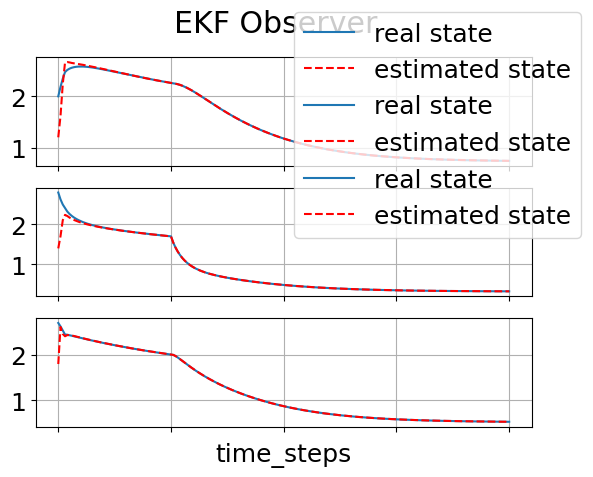

In [9]:
model, x1, x2, x3, u1, u2 = template_model()
simulator = template_simulator(model)
#simulator_ekf = template_simulator(model)
ekf = template_ekf(model)

""" User settings: """
#show_animation = True
#store_results = False

# simulation horizon
N_sim = 200
np.random.seed(1)
# setting up model variances with a generic value
q = 1e-3 * np.ones(model.n_x)
r = 1e-2 * np.ones(model.n_y)
#q = 0 * np.ones(model.n_x)
#r = 0 * np.ones(model.n_y)
Q = np.diag(q.flatten())
R = np.diag(r.flatten())

# initial states of model
x0_true = np.array([2, 2.8, 2.7]).reshape([-1, 1])
#x0 = np.zeros(model.n_x)
x0 = np.array([1.2, 1.4, 1.8]).reshape([-1, 1])

simulator.x0 = x0_true
ekf.x0 = x0
simulator.set_initial_guess()

ekf.set_initial_guess()

x0_simulator = [x0_true]
x0_ekf = [x0]

for k in range(N_sim):
    u0 = np.array([0.0001, 0.0001]).reshape([-1, 1])
    # Simulate with process and measurement noise
    y_next = simulator.make_step(u0, v0=0.001*np.random.randn(model.n_v,1))

    
    x0 = ekf.make_step(y_next = y_next, u_next = u0, Q_k=Q, R_k=R)

    
    x0_simulator.append(simulator._x0.master)
    x0_ekf.append(x0)

print(len(x0_simulator))
print(len(x0_ekf))

def visualize(x_data, x_hat_data):
    x_data = np.concatenate(x_data, axis=1)
    x_hat_data = np.concatenate(x_hat_data, axis=1)

    fig, ax = plt.subplots(model.n_x)
    fig.suptitle('EKF Observer')

    for i in range(model.n_x):
        ax[i].plot(x_data[i, :], label='real state')
        ax[i].plot(x_hat_data[i, :],"r--", label='estimated state')
        ax[i].set_xticklabels([])

    ax[-1].set_xlabel('time_steps')
    fig.legend()
    plt.show()

visualize(x0_simulator, x0_ekf)


# Plot

In [6]:
mpc_graphics = do_mpc.graphics.Graphics(ekf.data)

from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      

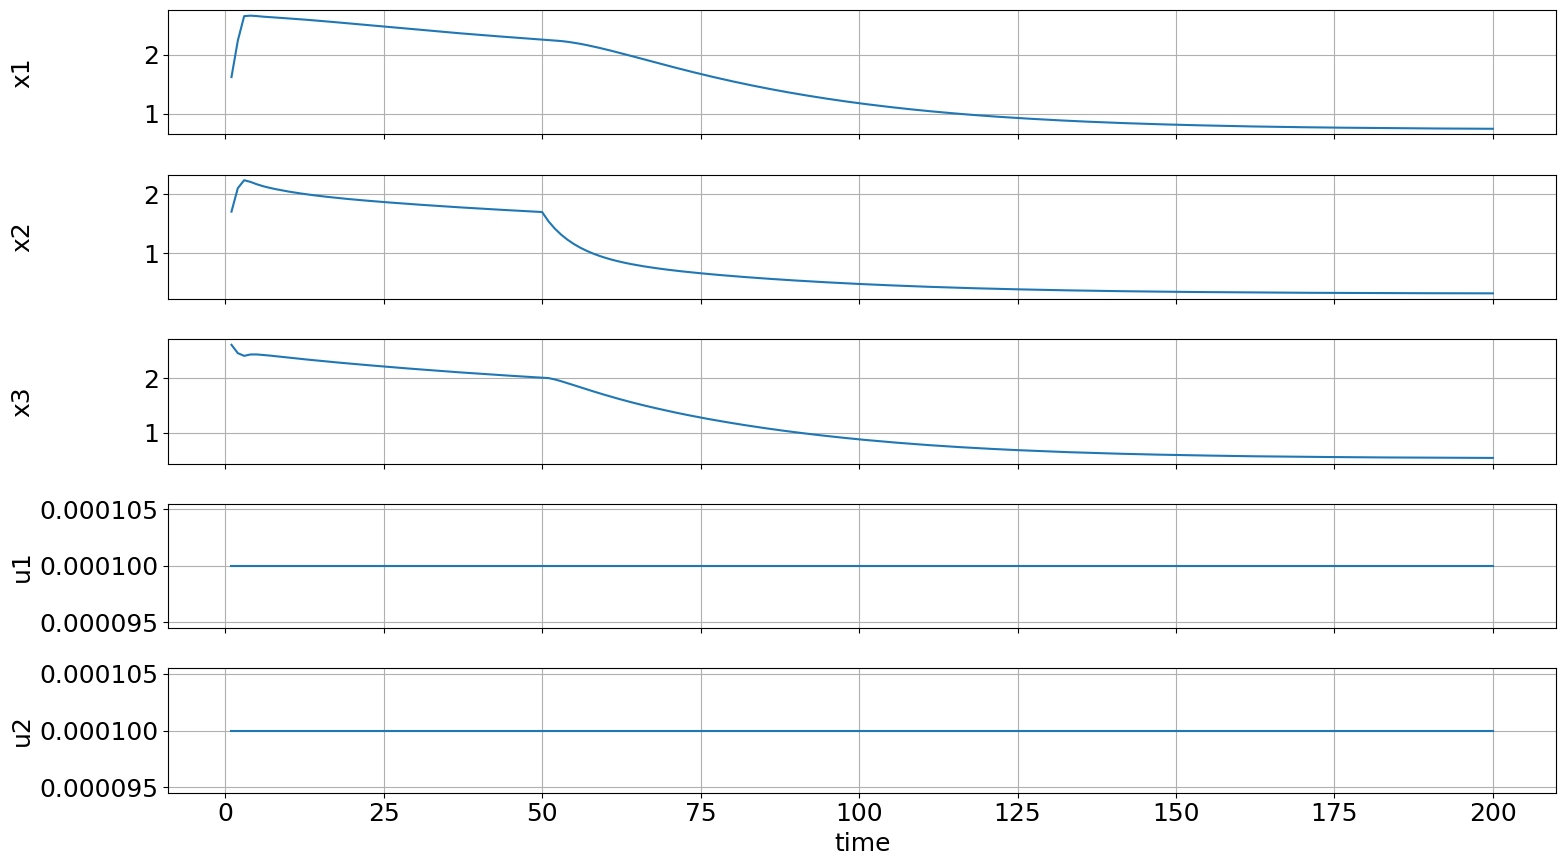

In [7]:
#%%capture
#fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
# Configure plot:
#mpc_graphics.add_line(var_type='_x', var_name='x1', axis=ax[0])
#mpc_graphics.add_line(var_type='_x', var_name='x2', axis=ax[1])
#mpc_graphics.add_line(var_type='_x', var_name='x3', axis=ax[2])

#mpc_graphics.add_line(var_type='_u', var_name='u1', axis=ax[3])
#mpc_graphics.add_line(var_type='_u', var_name='u2', axis=ax[4])
#ax[0].set_ylabel('h_tank_1 [m]')
#ax[1].set_ylabel('h_tank_2 [m]')
#ax[2].set_ylabel('h_tank_3 [m]')
#ax[3].set_ylabel('Q_1 [m3/s]')
#ax[4].set_ylabel('Q_2 [m3/s]')
#ax[4].set_xlabel('time [s]')
t_step = 1

fig, ax, graphics = do_mpc.graphics.default_plot(ekf.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
ax[0].axhline(y=x1,xmin=0,xmax=N_sim*t_step,color='r',linestyle='dashed')
ax[1].axhline(y=x2,xmin=0,xmax=N_sim*t_step,color='r',linestyle='dashed')
ax[2].axhline(y=x3,xmin=0,xmax=N_sim*t_step,color='r',linestyle='dashed')
ax[3].axhline(y=u1,xmin=0,xmax=N_sim*t_step,color='r',linestyle='dashed')
ax[4].axhline(y=u2,xmin=0,xmax=N_sim*t_step,color='r',linestyle='dashed')
plt.show()